# Clasificación de flores

Mariana Michell Flores Monroy

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Importamos las bibliotecas que se van a necesitar (fastai, pytorch)


In [2]:
import fastai as fai
import fastai.vision as fv
from pathlib import Path 

Tenemos una carpeta con subcarpetas de las clasificaciones de flores y en cada subcarpeta hay imagenes de la especie de flores respectivas a cada subcarpeta (Sé que no las ocupo porque los datos ya están descargados, pero los pongo para que no se me olvide)

In [3]:
#!wget https://my.pcloud.com/publink/show?code=XZiwtw7Z15TY80dPm4b3KwmNcf1ChfphgM5y
#!tar xzf flowers.tar.gz

In [4]:
!ls flowers 

train  valid


In [5]:
!ls flowers/train

alpine-sea-holly    fire-lily		       peruvian-lily
anthurium	    foxglove		       petunia
artichoke	    frangipani		       pincushion-flower
azalea		    fritillary		       pink-primrose
ball-moss	    garden-phlox	       pink-yellow-dahlia
balloon-flower	    gaura		       poinsettia
barbeton-daisy	    gazania		       primula
bearded-iris	    geranium		       prince-of-wales-feathers
bee-balm	    giant-white-arum-lily      purple-coneflower
bird-of-paradise    globe-flower	       red-ginger
bishop-of-llandaff  globe-thistle	       rose
blackberry-lily     grape-hyacinth	       ruby-lipped-cattleya
black-eyed-susan    great-masterwort	       siam-tulip
blanket-flower	    hard-leaved-pocket-orchid  silverbush
bolero-deep-blue    hibiscus		       snapdragon
bougainvillea	    hippeastrum		       spear-thistle
bromelia	    japanese-anemone	       spring-crocus
buttercup	    king-protea		       stemless-gentian
californian-poppy   lenten-rose		       sunflower
camellia	    lotus		       sweet

Guardamos la carpeta de flowers en una nueva variable (Flores) para poder hacer "operaciones" con ellas

In [6]:
Flores = Path("flowers")

Usaremos el metodo transform para realizar transformadas de las imagenes
flip_vert es para voltear verticalmente la imagen
max_rotate es qué tanto se puede rotar la imagen

In [7]:
transformaciones = fv.get_transforms(flip_vert=True, max_rotate=360,
                         max_zoom=1.25, max_lighting=0.3)

Aquí tomamos las imagenes transformadas y las reducimos a 224 pixeles con un batch size de 64

In [8]:
datos = (fv.ImageDataBunch
        .from_folder(Flores, ds_tfms=transformaciones, size=224, bs=64)
        .normalize(fv.imagenet_stats))

Mostramos las imagenes

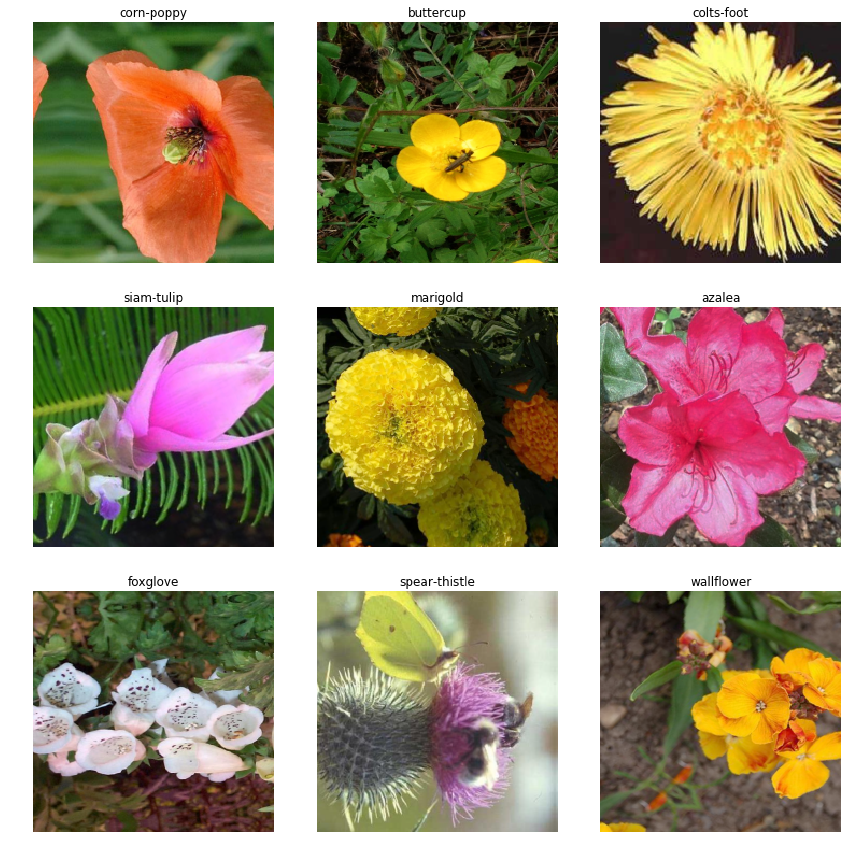

In [9]:
datos.show_batch(rows=3)

# ENTRENAMIENTO

En esta parte vamos a crear algo llamado learner, que se va a encargar de hacer el aprendizaje con base al entrenamiento de este.
resnet18 - es la arquitectura del learner (y es todo lo que sé)
En metrics le pedimos que nos muestre el acuracy de la clasificación y el error del mismo

In [10]:
learner = fv.create_cnn(datos, fv.models.resnet18, 
                        metrics=[fai.metrics.accuracy, fai.metrics.error_rate], wd=0.1)

Ahora se usa la función fit_one_cycle para entrenar la red neuronal de una manera rápida (supongo que solo hace entrenamiento en las salidas o algo así, no sé...)

In [11]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate
1,1.779633,0.883224,0.812253,0.187747


In [12]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.949302,0.506798,0.877470,0.122530
2,0.620492,0.314956,0.915020,0.084980
3,0.439864,0.217517,0.942688,0.057312
4,0.344389,0.203238,0.948617,0.051383


Como no sabes cual es la taza de aprendizaje que debemos utilizar, vamos a graficar los errores que comete la red neuronal con diferentes tazas de aprendizaje

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


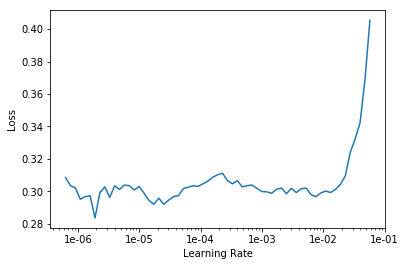

In [13]:
learner.lr_find(); learner.recorder.plot()

Como podemos ver, la taza de aprendizaje con menos "errores" es de 1e-2
Así que usaremos eso para realizar un nuevo entrenamiento del learner

In [14]:
learner.fit_one_cycle(4, max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.647543,1.492646,0.614625,0.385375
2,0.829512,0.544835,0.828063,0.171937
3,0.464532,0.206742,0.936759,0.063241
4,0.275545,0.139499,0.962451,0.037549


Y salvamos el entrenamiento del learner

In [15]:
learner.save('stage1')

Ahora ploteamos los errores en los sets de train y validation

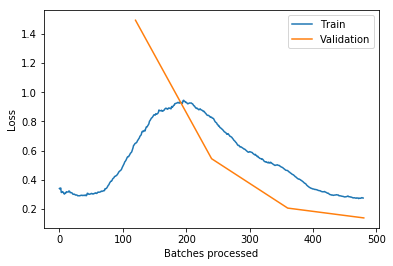

In [16]:
learner.recorder.plot_losses()

Esto no recuedo para qué sirve, pero parece que grafica el error y accuracy del learner

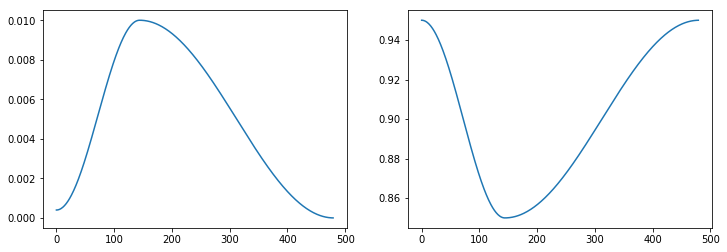

In [17]:
learner.recorder.plot_lr(show_moms=True)

Como expliqué anteriormente, solo hicimos entrenamiento en las últimas capas porque el learner ya venía con una arquitectura entrenada, así que se tienen que "descongelar" para poder entrenar la red completamente

In [18]:
learner.unfreeze()

Con este comando se va a buscar la mejor taza de aprendizaje ya con la red completa 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


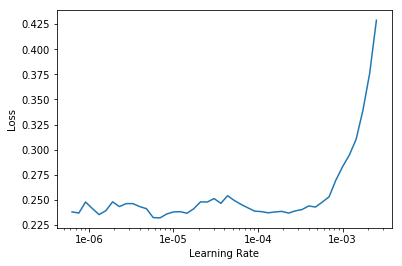

In [19]:
learner.lr_find(); learner.recorder.plot()

Antes de entrenar toda la red se van a modificar las primeras capas. y se agrega una taza de aprendizaje de entre 1e-5 a 1e-4 ya que ahí se vió un menor error

In [20]:
learner.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.221163,0.129189,0.958498,0.041502
2,0.201655,0.111765,0.962451,0.037549
3,0.181644,0.102128,0.968379,0.031621
4,0.150792,0.097462,0.966403,0.033597
5,0.141904,0.097893,0.972332,0.027668


Y salvamos los resultados 

In [21]:
learner.save('stage2')

Ahora vemos el resultado de la clasificación en el conjunto de validation

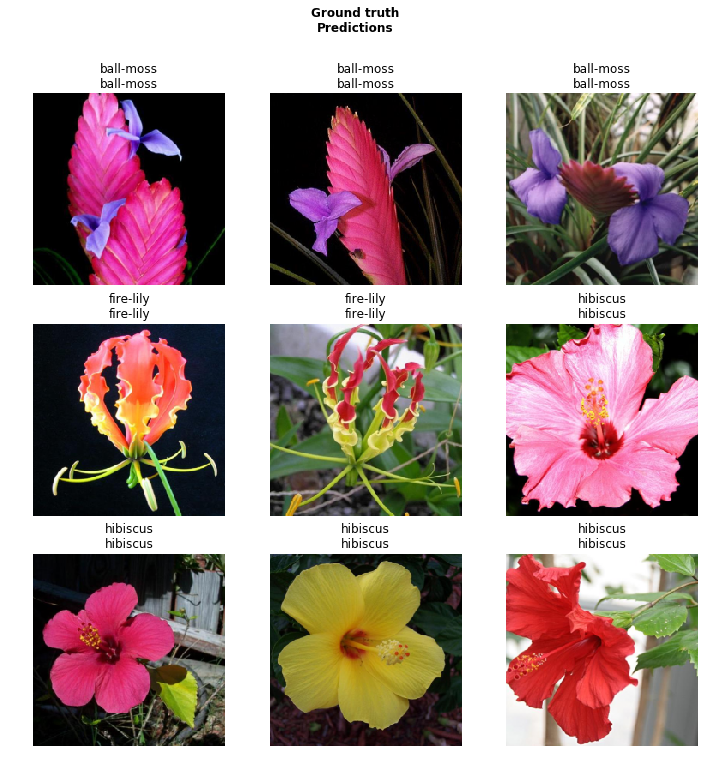

In [24]:
learner.show_results(ds_type=fai.data_block.DatasetType.Valid, rows=3)

Checamos el accuracy

In [25]:
fai.metrics.accuracy(*learner.TTA())

tensor(0.9802)

Y finalmente vemos los errores de clasificación

In [26]:
interpretacion = learner.interpret()

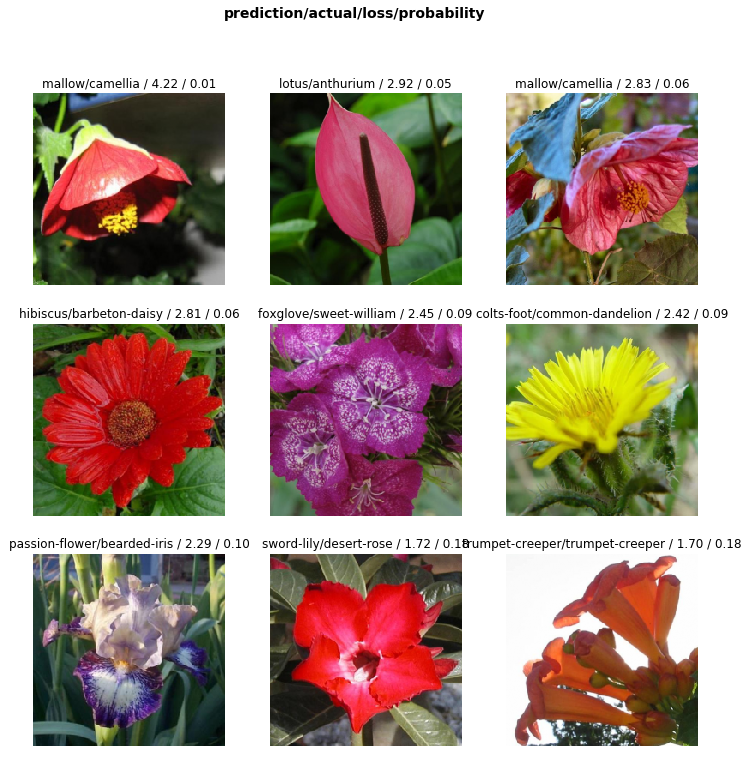

In [27]:
interpretacion.plot_top_losses(9)

Como ya habíamos visto en clase, efectivamente hay unas clasificaciones erroneas, pero algunas de las que vemos en este caso son "correctas", el problema es que en el dataset vienen mal clasificadas

# Conlusiones

Pude notar que algo importante para la clasificación fue hacer transforaciones al data set, ya que de esta manera puede "reconocer" flores que no se encuentren en posiciones centradas en la imagen. 
También algo importante que noté es que no hay como una "formula" global para la clasificación ya que ésta depende de los datos con los que se trabaja y lo que se quiere lograr con ellos. Así que aunque este clasificador funcionó bien a la hora de tabajar con flores, puede que a la hora de trabajar con otro Dataset, no dé buenos resutados. Así que el chiste es entender lo que se quiere lograr y entender cómo llegar a eso.